# Data Preparation

In [1]:
# import required modules for data preparation tasks
import requests, zipfile, StringIO
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import re
import json
import os

### 1. Get the Data for 2014 from zip Files

First, we want to open and combine the zipped data files for each month that have been downloaded according to the process outlined in `01_Data Aquisition.ipynb`.

In [ ]:
%%time
rawData = pd.DataFrame()
files = os.listdir('cache/predictionData/')
for dfile in files:
    path = 'cache/predictionData/{f}'.format(f = dfile)
    rawData = rawData.append(pd.read_csv(path))
print rawData.head(3)

In [ ]:
# reads all predefined months for a year and merge into one data frame
rawData = pd.DataFrame()
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for m in months:
    z = zipfile.ZipFile('cache/{y}{mo}.zip'.format(y=str(2014), mo = m))
    rawData = rawData.append(pd.read_csv(z.open(z.namelist()[0])))
    print "Downloaded", m
# reset index of complete dataset for delays to prepare merging in next step
rawData.reset_index(inplace=True)

Downloaded 01
Downloaded

### 2. Combine Data with External Aircraft Data

We also have two tables containing infos about the aircraft and its manufacturer available. Both files will be loaded.

In [7]:
z = zipfile.ZipFile('externalData/AircraftInformation.zip')
df_master  = pd.DataFrame.from_csv(z.open('MASTER.txt'))
df_aircrafts  = pd.DataFrame.from_csv(z.open('ACFTREF.txt'))

We can now join these two tables based on their common ID that is saved in the column `MFR MDL CODE` of the master table and in the index of the aircraft table respectively.

In [8]:
master = df_master[['MFR MDL CODE', 'YEAR MFR']].reset_index()
aircrafts = df_aircrafts['MFR'].reset_index()
master.columns = ['TAIL_NUM', 'CODE', 'YEAR']
aircrafts.columns = ['CODE', 'MFR']
joined = pd.merge(master, aircrafts, how='left', on='CODE')

We now join this aircraft information with our delay data and extend the original dataset with the two new features: The year in which the aircraft was built (to determine the age) and the manufacturer.

In [9]:
delayFinal = rawData[['TAIL_NUM','AIRLINE_ID']]
delayFinal.TAIL_NUM = delayFinal.TAIL_NUM.str.strip('N')
delaymfr = pd.merge(delayFinal, joined, how='left', on=['TAIL_NUM'])
rawData['AIRCRAFT_YEAR'] = delaymfr.YEAR
rawData['AIRCRAFT_MFR'] = delaymfr.MFR

/Users/David/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### 3. Combine Data with External Airport Location Data

Now we load an external dataset that contains the geolocations for each commercial airport in the world. We filter this to get only the airports in the US and then assign the respective geocode of the origin airport to our original delay dataset by merging both tables.

In [10]:
airportLocation = pd.DataFrame.from_csv('externalData/airport_codes_with_geo_name_ids_and_nl_names-2008-04-14.csv', header=None)
usAirports = airportLocation[airportLocation[4]=='US'].reset_index()
usAirports = usAirports[[0, 5, 6]]
usAirports.columns = ['ORIGIN', 'LAT', 'LONG']
rawData = pd.merge(rawData, usAirports, how='left', on='ORIGIN')

In [13]:
1.0*sum(rawData.LAT.isnull())/rawData.shape[0]

0.007050916258277116

Just 0.7% of alll flight origins could not be located, so the merge was quite successful.

### 4. Combine Data with External Weather Data

As outlined in `01_Data Aquisition.ipynb`, we scraped historical weather data for major US airports from the web. This data can be used as additional features for each flight to get information about the current weather conditions at the airport of the departure.

In [81]:
weatherFile = os.path.join('cache', 'weather_data.json')
with open(weatherFile) as infile:
    weatherDict = json.load(infile)

In [82]:
dates = []
frames = []
for datapoint in weatherDict['JFK']:
    date = datapoint['date']
    frames.append(pd.DataFrame(datapoint['data'], index=['%s-%s-%s' % (date[0:4], date[4:6], date[6:8])]))
weather_df = pd.concat(frames).reset_index()

In [84]:
jfk_delays = completeData[completeData.ORIGIN=='JFK']

In [86]:
jfk_dalayWeather = pd.merge(jfk_delays, weather_df, how='left', left_on='FL_DATE', right_on = 'index')

In [88]:
jfk_dalayWeather.to_csv('cache/jfk_weather_2014.csv', encoding='UTF-8')

### 5. Creation of the Final Dataset

The columns we now have in the dataset are:

In [18]:
rawData.columns

Index([u'index', u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH',
       u'DAY_OF_WEEK', u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID',
       u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'ORIGIN_STATE_ABR', u'ORIGIN_STATE_FIPS', u'ORIGIN_STATE_NM',
       u'ORIGIN_WAC', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_ABR',
       u'DEST_STATE_FIPS', u'DEST_STATE_NM', u'DEST_WAC', u'CRS_DEP_TIME',
       u'DEP_TIME', u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15',
       u'DEP_DELAY_GROUP', u'DEP_TIME_BLK', u'TAXI_OUT', u'WHEELS_OFF',
       u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY',
       u'ARR_DELAY_NEW', u'ARR_DEL15', u'ARR_DELAY_GROUP', u'ARR_TIME_BLK',
       u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'CRS_ELAPSED_TIME',
       u'ACTUAL_ELAPSED_TIME', u'AIR_TIME', u'FLIGHTS', u'DISTANCE',
       u'DISTANCE_GROUP', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY',
       u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY', u'FIRST_DEP_TI

However, we just need a subset of these columns for our analysis:

In [19]:
selectedColumns = [u'index', u'FL_DATE', u'UNIQUE_CARRIER', u'TAIL_NUM', u'FL_NUM', 
                   u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY', u'TAXI_OUT', 
                   u'WHEELS_OFF', u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', 
                   u'CANCELLED', u'CANCELLATION_CODE', u'AIR_TIME', u'DISTANCE', 
                   u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY', 
                   u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR',u'LAT', u'LONG']

In [20]:
complete2014Data = rawData[selectedColumns]

The resulting dataframe `complete2014Data` will be locally stored as csv file.

In [21]:
complete2014Data.to_csv('cache/complete2014Data.csv')

### 6. Creation of the Prediction Datasets

### REMOVE LATER: Exploratory Analysis

In [106]:
mask = (completeData.ARR_TIME>2000) & (completeData.ARR_TIME<2100)
sum(completeData.ARR_DELAY>60)/float(len(completeData))

0.061459727815903302

In [109]:
print sum(completeData.ARR_DELAY.fillna(0))

41611569.0


In [12]:
completeData = pd.DataFrame.from_csv('cache/complete2014Data.csv')

In [42]:
subset = completeData[[u'MONTH', u'DAY_OF_MONTH',
       u'UNIQUE_CARRIER', u'AIRLINE_ID',
       u'CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME',
       u'DEP_TIME', u'WEATHER_DELAY', u'NAS_DELAY']]

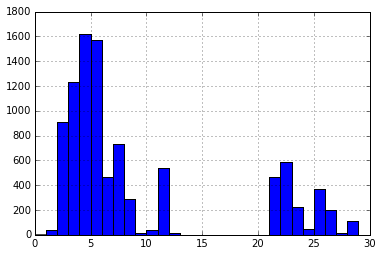

In [46]:
subset[(subset.WEATHER_DELAY > 0) & (subset.ORIGIN == 'JFK')].sort(columns='DAY_OF_MONTH').DAY_OF_MONTH.hist(bins = np.arange(0,30,1))
#subset[(subset.DEP_TIME == 1144) & (subset.CRS_DEP_TIME == 1129)]
#z = zipfile.ZipFile('cache/201411.zip')
#test = pd.read_csv(z.open(z.namelist()[0]))

In [47]:
# percentage of missing aircraft information
sum(completeData.AIRCRAFT_YEAR.isnull())/(1.0*len(completeData.AIRCRAFT_YEAR.isnull()))

0.29173914978101445

In [34]:
years = [int(year) for year in delaymfr.YEAR.str.strip().values if (not year != year and (len(year)==4))]
plt.xlim(1980,2020)
plt.hist(years, bins=np.arange(1950, 2020, 1))

In [3]:
completeData = pd.DataFrame.from_csv('cache/complete2014Data.csv')

/Users/David/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (44,70,71,76,96) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [8]:
reducedData.head()

,UNIQUE_CARRIER,CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,...,ARR_TIME_BLK,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
133763,US,US,N954UW,2014,ATL,PHL,1945,1936,-9,0,...,2100-2159,85,1,666,3,NaN,NaN,NaN,NaN,NaN
3261557,WN,WN,N218WN,497,EWR,STL,705,708,3,3,...,0800-0859,131,1,872,4,NaN,NaN,NaN,NaN,NaN
4374547,MQ,MQ,N856MQ,2964,GRR,DFW,1630,1625,-5,0,...,1800-1859,182,1,931,4,0,0,65,0,0
3554348,US,US,N205UW,2093,CLT,DFW,1120,1117,-3,0,...,1300-1359,125,1,936,4,NaN,NaN,NaN,NaN,NaN
3508069,DL,DL,N902DE,2493,BHM,ATL,1615,1614,-1,0,...,1800-1859,32,1,134,1,NaN,NaN,NaN,NaN,NaN


In [7]:
selectedCols = [u'UNIQUE_CARRIER',
       u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN',
        u'DEST', u'CRS_DEP_TIME',
       u'DEP_TIME', u'DEP_DELAY', u'DEP_DELAY_NEW',  u'DEP_TIME_BLK', u'TAXI_OUT', u'WHEELS_OFF',
       u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY',
       u'ARR_DELAY_NEW', u'ARR_DEL15', u'ARR_DELAY_GROUP', u'ARR_TIME_BLK', u'AIR_TIME', u'FLIGHTS', u'DISTANCE',
       u'DISTANCE_GROUP', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY',
       u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY']
reducedData = completeData[selectedCols].ix[random.sample(completeData.index, 1000)]
reducedData.to_csv('cache/reduced2014Data.csv')